In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as mt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from sklearn.metrics import roc_curve, auc
from wordcloud import WordCloud, STOPWORDS

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
fake_job_postings = pd.read_csv('fake_job_postings.csv')
fake_job_postings.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
fake_job_postings.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
fake_job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
fake_job_postings.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
fake_job_postings.location= fake_job_postings.location.fillna('')

In [ ]:
fake_job_postings_US = fake_job_postings[fake_job_postings['location'].str.contains("US")]
fake_job_postings_US .head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
len(fake_job_postings_US)/len(fake_job_postings)

0.5959731543624162

In [ ]:
loc_split =[]
for loc in fake_job_postings_US.location:
    loc_split.append(loc.split(','))
loc_split = pd.DataFrame(loc_split)
loc_split=loc_split[[1,2]]
loc_split = loc_split.rename(columns={1: "state", 2:'city'})
loc_split.head()


,state,city
0,NY,New York
1,IA,Wever
2,DC,Washington
3,FL,Fort Worth
4,MD,


In [ ]:
fake_job_postings_US = fake_job_postings_US.reset_index()
fake_job_postings_US.head()

,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
2,3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
3,4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
4,5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
fake_job_postings_US = fake_job_postings_US.join(loc_split)
fake_job_postings_US.head()

,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,state,city
0,0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,NY,New York
1,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,IA,Wever
2,3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,DC,Washington
3,4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,FL,Fort Worth
4,5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0,MD,


In [ ]:
fake_job_postings_US = fake_job_postings_US[fake_job_postings_US['city'].notna()]
fake_job_postings_US = fake_job_postings_US[fake_job_postings_US['state'].notna()]

In [ ]:
fake_job_postings_US['state_city'] = fake_job_postings_US['state'] + ", " + fake_job_postings_US['city']
fake_job_postings_US.head()

,index,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,state,city,state_city
0,0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,NY,New York,"NY, New York"
1,2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,IA,Wever,"IA, Wever"
2,3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,DC,Washington,"DC, Washington"
3,4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,FL,Fort Worth,"FL, Fort Worth"
4,5,6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0,MD,,"MD,"


In [ ]:
#to remove empty spaces before and after the str
fake_job_postings_US.city = fake_job_postings_US.city.str.strip()
fake_job_postings_US.state = fake_job_postings_US.state.str.strip()

In [ ]:
fake_job_postings_US=fake_job_postings_US.drop(columns=['index'])

In [ ]:
fake_job_postings_US.to_csv('/content/fake_job_postings_us.csv')

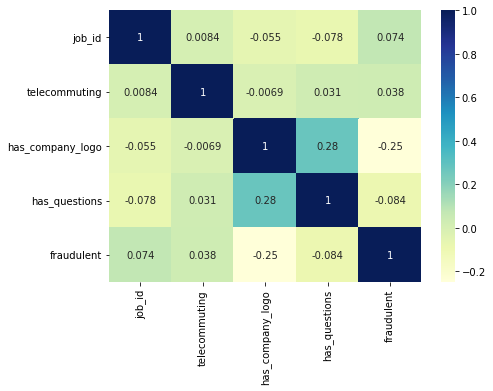

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(fake_job_postings_US.corr(),annot=True, cmap="YlGnBu")

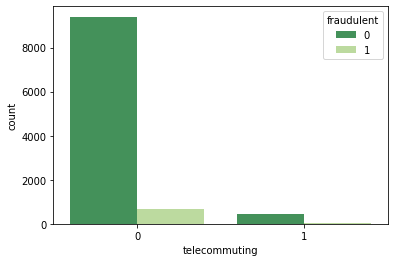

In [ ]:
sns.countplot(x ='telecommuting', hue = "fraudulent", data = fake_job_postings_US,palette="YlGn_r")
plt.show()

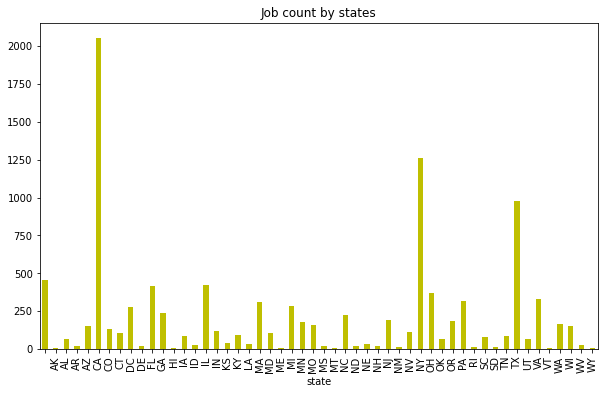

In [ ]:
plt.figure(figsize=(10,6))
fake_job_postings_US.groupby('state').fraudulent.count().plot(kind='bar', title='Job count by states', color='y');

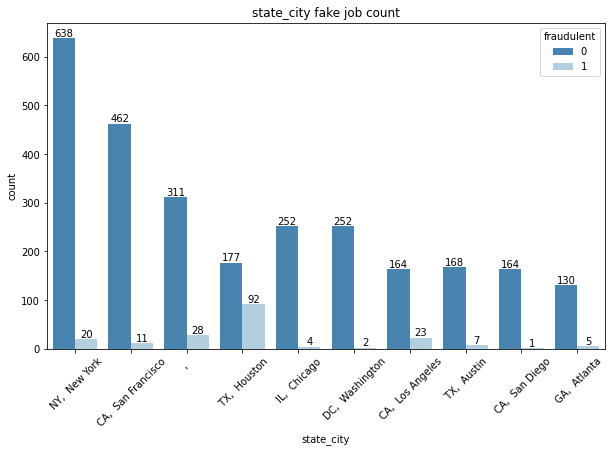

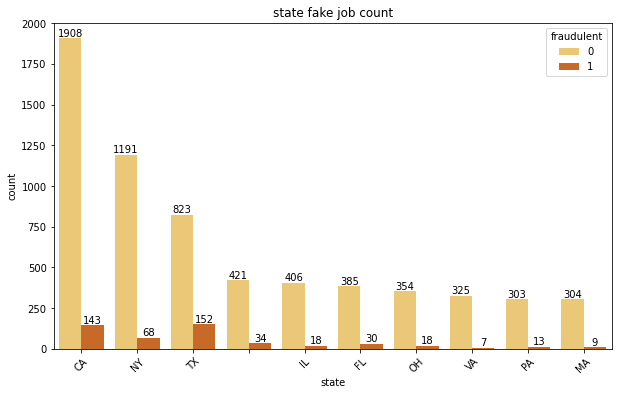

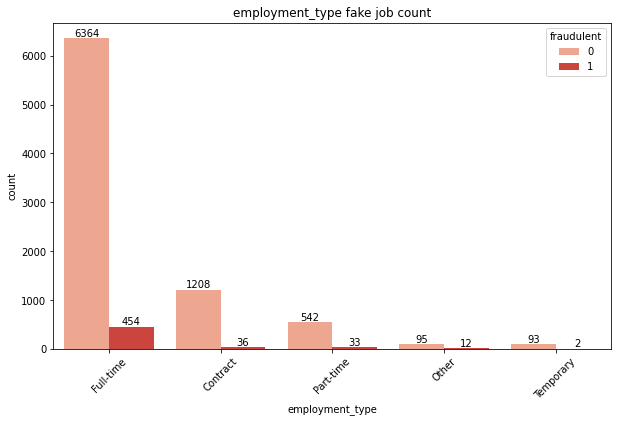

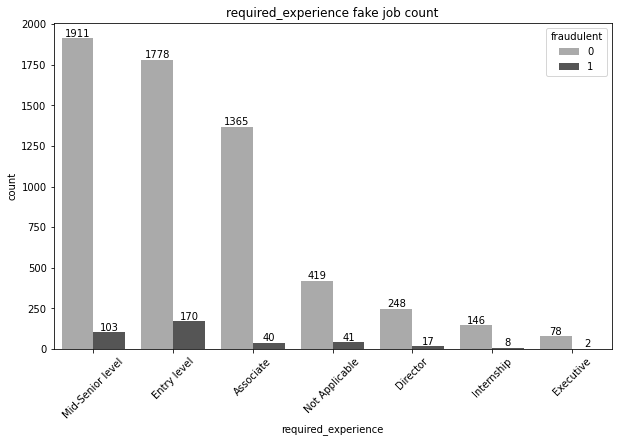

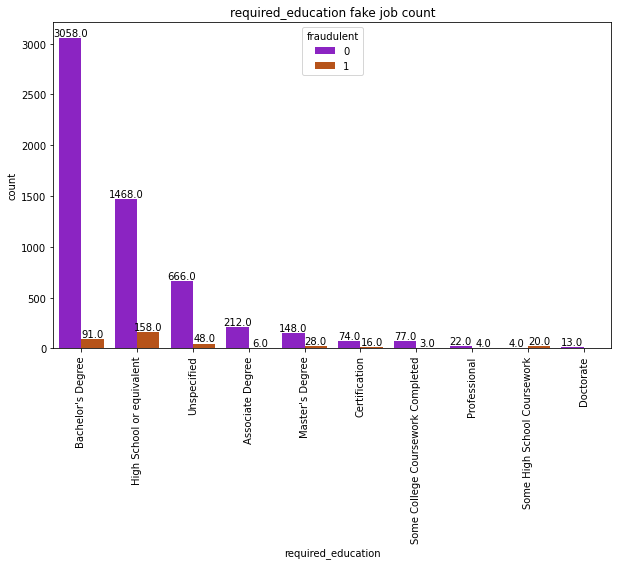

In [ ]:
def sns_countplot(feature,color,rotation=45):
    plt.figure(figsize=(10,6))
    ax=sns.countplot(x=feature, data=fake_job_postings_US, hue="fraudulent",
              order=fake_job_postings_US[feature].value_counts().iloc[:10].index,palette=color)
    for p in ax.patches:
      ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2.0, p.get_height()),ha = 'center', va = 'center', xytext = (0, 5),textcoords = 'offset points')
    plt.xticks(rotation=rotation)
    title = feature + ' fake job count'
    plt.title(title)
    plt.show()

sns_countplot('state_city','Blues_r')

sns_countplot('state','YlOrBr')

sns_countplot('employment_type','Reds')

sns_countplot('required_experience','binary')

sns_countplot('required_education','gnuplot',90)

In [ ]:
fraudulent_data=fake_job_postings_US[fake_job_postings_US['fraudulent']==1]

In [ ]:
def word_cloud(feature,color):
  plt.figure(figsize=(20,5))
  text = " ".join(feature for feature in fraudulent_data[feature])
  stopwords=set(STOPWORDS)
  wordcloud = WordCloud(background_color="black",width=1600, height=800,stopwords=stopwords,colormap=color).generate(text)
  plt.imshow(wordcloud,interpolation="bilinear")
  plt.axis("off")
  plt.show()

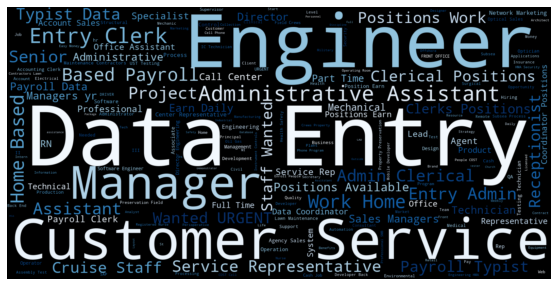

In [ ]:
word_cloud('title','Blues_r')

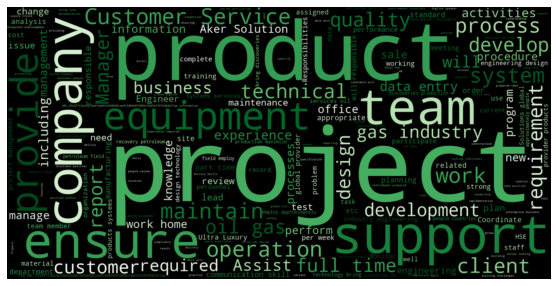

In [ ]:
word_cloud('description','Greens_r')

In [ ]:
a=fake_job_postings_US[fake_job_postings_US.fraudulent==0]['employment_type'].value_counts()
a.values
b=fake_job_postings_US[fake_job_postings_US.fraudulent==1]['employment_type'].value_counts()
b.values

array([454,  36,  33,  12,   2])

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
labels = ['Full-time', 'Contract', 'Part-time', 'Other', 'Temporary']
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=a.values, name="Real"),1, 1)
fig.add_trace(go.Pie(labels=labels, values=b.values, name="Fake"), 1, 2)
fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(title_text="Employment_type vs Fraudulent ",annotations=[dict(text='Real', x=0.18, y=0.5, font_size=20, showarrow=False),dict(text='Fake', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [ ]:
a=fake_job_postings_US[fake_job_postings_US.fraudulent==0]['telecommuting'].value_counts()
b=fake_job_postings_US[fake_job_postings_US.fraudulent==1]['telecommuting'].value_counts()

In [ ]:
df=pd.DataFrame({'type':['Real','Fake','Real','Fake'],'telicom':['work_from_office','work_from_office','work_from_home','work_from_home'],'count':[a[0],b[0],a[1],b[1]]})

In [ ]:
import plotly.express as px
fig = px.scatter(df, y="type", x="count",color="telicom", symbol="telicom")
fig.update_traces(marker_size=10)
fig.show()

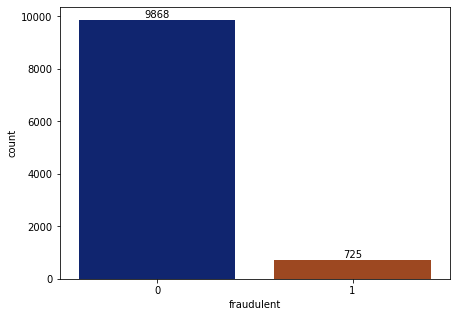

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='fraudulent', data=fake_job_postings_US,palette="dark");
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2.0, p.get_height()),ha = 'center', va = 'center', xytext = (0, 5),textcoords = 'offset points')

In [ ]:

def missing_values_count(feature, title='None'):
    y_axis = fake_job_postings_US[fake_job_postings_US[feature].isna()][['fraudulent', feature]]
    y_axis = y_axis.fraudulent.value_counts()
    y_axis.plot(kind='bar',color = 'darkred')
    plt.ylabel('Count')
    plt.xlabel('Category')
    title = "Number of empty " + title + " in fraudulent and non-fraudulent"
    plt.title(title)
    plt.xticks(rotation=0)
    plt.show()
    return 0

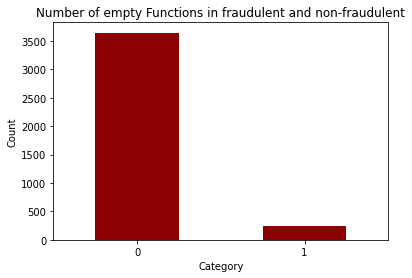

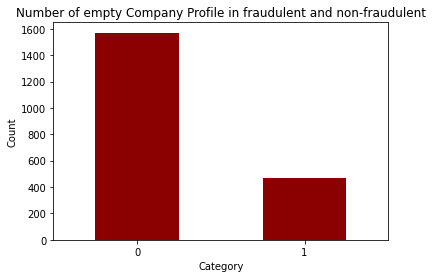

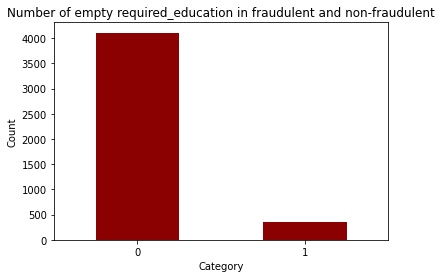

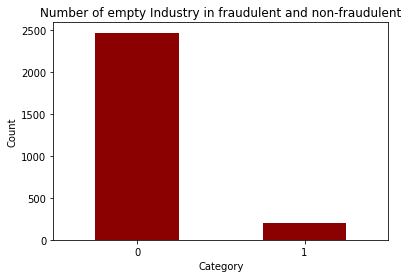

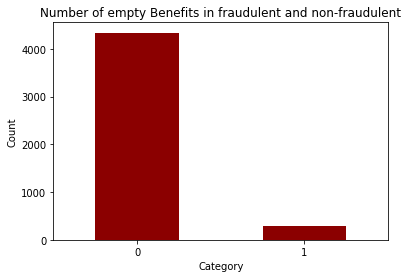

0

In [ ]:
missing_values_count('function', 'Functions')
missing_values_count('company_profile', 'Company Profile')
missing_values_count('required_education', 'required_education')
missing_values_count('industry', 'Industry')
missing_values_count('benefits', 'Benefits')

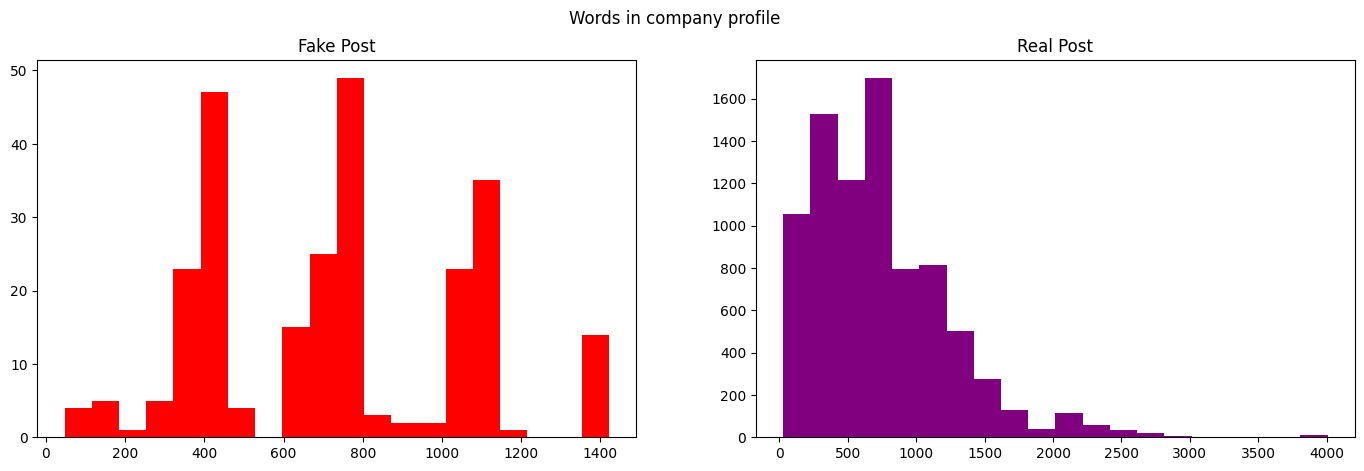

In [ ]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
num=fake_job_postings_US[fake_job_postings_US["fraudulent"]==1]['company_profile'].str.len()
ax1.hist(num,bins = 20,color='r')
ax1.set_title('Fake Post')
num=fake_job_postings_US[fake_job_postings_US["fraudulent"]==0]['company_profile'].str.len()
ax2.hist(num, bins = 20,color='purple')
ax2.set_title('Real Post')
fig.suptitle('Words in company profile')
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


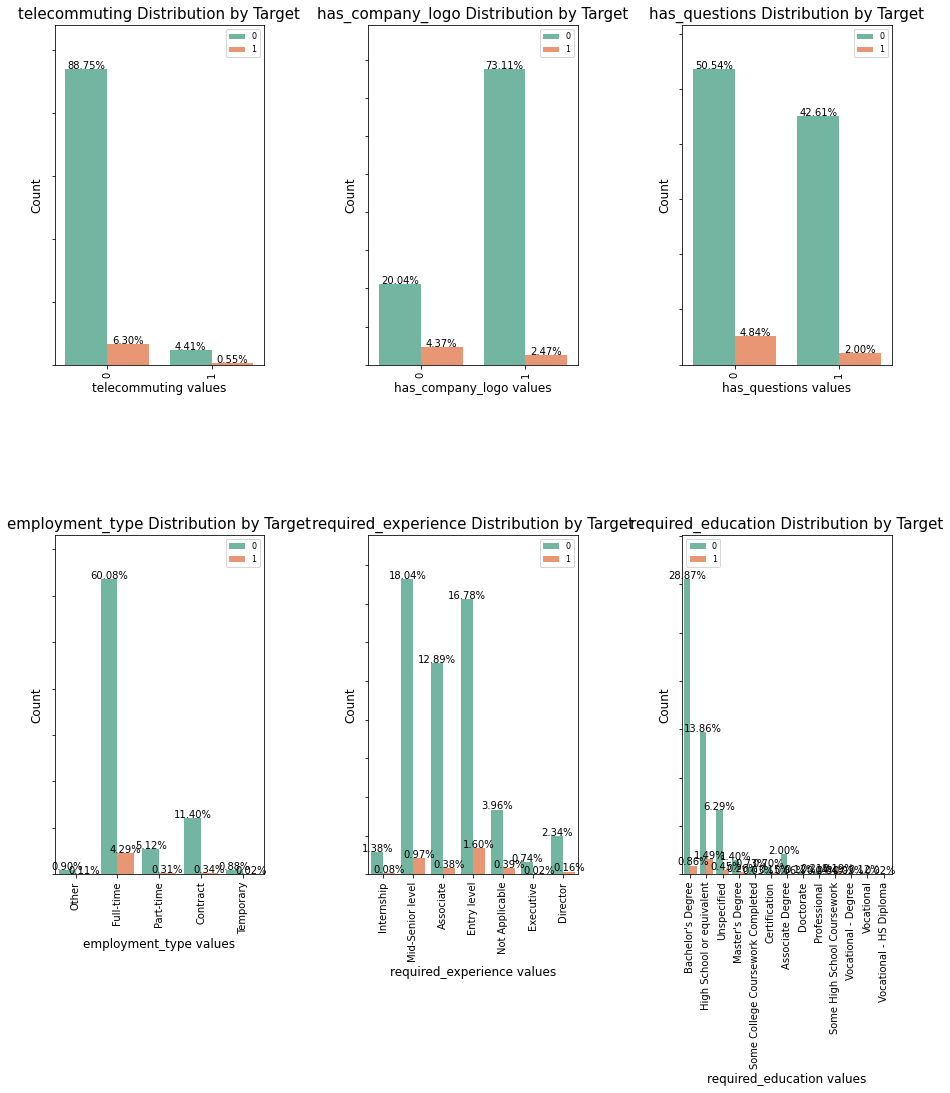

In [ ]:
cat_cols = ["telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education",]
# visualizating catagorical variable by target
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 3, wspace=0.5, hspace=0.5) # The grid of chart
plt.figure(figsize=(15,25)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(fake_job_postings_US[cat_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=fake_job_postings_US, hue='fraudulent', palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=15) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label
    xlabels = ax.get_xticklabels() 
    ylabels = ax.get_yticklabels() 
    ax.set_xticklabels(xlabels,  fontsize=10)
    ax.set_yticklabels(ylabels,  fontsize=10)
    plt.legend(fontsize=8)
    plt.xticks(rotation=90) 
    total = len(fake_job_postings_US)
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=10) 
    ax.set_ylim(0, max(sizes) * 1.15) #set y limit based on highest heights


plt.show()

In [ ]:
fake_job_postings_US.fillna(" ",inplace = True)

fake_job_postings_US['text'] =  fake_job_postings_US['title'] + ' ' + fake_job_postings_US['location'] + ' ' + fake_job_postings_US['company_profile'] + ' ' + \
        fake_job_postings_US['description'] + ' ' + fake_job_postings_US['requirements'] + ' ' + fake_job_postings_US['benefits'] + ' ' + \
        fake_job_postings_US['required_experience'] + ' ' + fake_job_postings_US['required_education'] + ' ' + fake_job_postings_US['industry'] + ' ' + fake_job_postings_US['function']


fake_job_postings_US.drop(['job_id', 'department', 'salary_range', 'title','location','department','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function', 'city', 'state_city', 'has_company_logo', 'has_questions', 'state'], axis = 1, inplace = True)

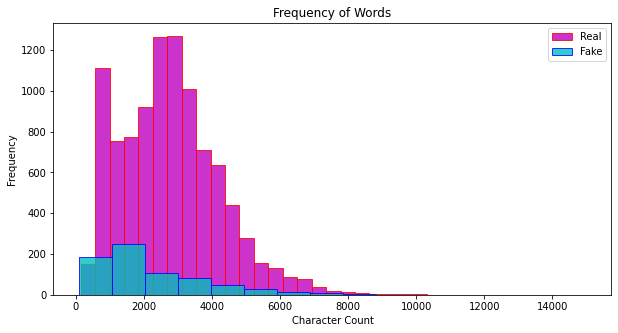

In [ ]:
plt.figure(figsize=(10,5))
fake_job_postings_US['character_count'] = fake_job_postings_US.text.apply(len)

fake_job_postings_US[fake_job_postings_US.fraudulent==0].character_count.plot(bins=35, kind='hist', color='m', 
                                       label='Real', alpha=0.8,edgecolor='red')
fake_job_postings_US[fake_job_postings_US.fraudulent==1].character_count.plot(kind='hist', color='c', 
                                       label='Fake', alpha=0.8,edgecolor='blue')

plt.legend()
plt.title('Frequency of Words')
plt.xlabel("Character Count");

In [ ]:
fig = px.box(fake_job_postings_US, x="fraudulent", y="character_count")
fig.show()

#Data Preprocessing

In [ ]:
import re

In [ ]:
lemmatizer = WordNetLemmatizer()
def text_cleaning(text):
    text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    text = text.lower() # text to lowercase
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if not word in stopwords.words('english')]
    return ' '.join(text) 

In [ ]:
fake_job_postings_US['text'] = fake_job_postings_US['text'].apply(text_cleaning)

In [ ]:
fake_job_postings_US['character_count'] = fake_job_postings_US.text.apply(len)

In [ ]:
fake_job_postings_US

,telecommuting,fraudulent,text,character_count
0,0,0,marketing intern u ny new york food created gr...,2031
1,0,0,commissioning machinery assistant cma u ia wev...,1991
2,0,0,account executive washington dc u dc washingto...,4464
3,0,0,bill review manager u fl fort worth spotsource...,3298
4,0,0,accounting clerk u md job overviewapex environ...,2657
...,...,...,...,...
10651,0,0,product manager u ca san francisco flite deliv...,2156
10652,0,0,recruiting coordinator u nc charlotte responsi...,1726
10653,0,0,javascript developer u sr javascript developer...,466
10654,0,0,payroll accountant u pa philadelphia weblinc e...,3615


In [ ]:
X = fake_job_postings_US[['text']]
y = fake_job_postings_US['fraudulent']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
X_train = count_vectorizer.fit_transform(X_train.text.values)
X_test = count_vectorizer.transform(X_test.text.values)

In [ ]:
nb= MultinomialNB()
nb.fit(X_train, y_train)
pred = nb.predict(X_test)
mt.accuracy_score(y_test, pred)

0.9676773455377574

In [ ]:
nn = MLPClassifier(alpha=0.002,solver='lbfgs',random_state=1,learning_rate_init=0.25)
nn.fit(X_train, y_train)
pred = nn.predict(X_test)
mt.accuracy_score(y_test, pred)

0.9756864988558352

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
mt.accuracy_score(y_test, pred)

0.9705377574370709

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
pred = neigh.predict(X_test)
mt.accuracy_score(y_test, pred)

0.9450800915331807

In [ ]:
lr = LogisticRegression(tol=0.002)
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
mt.accuracy_score(y_test, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9756864988558352

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
mt.accuracy_score(y_test, pred)

0.9748283752860412

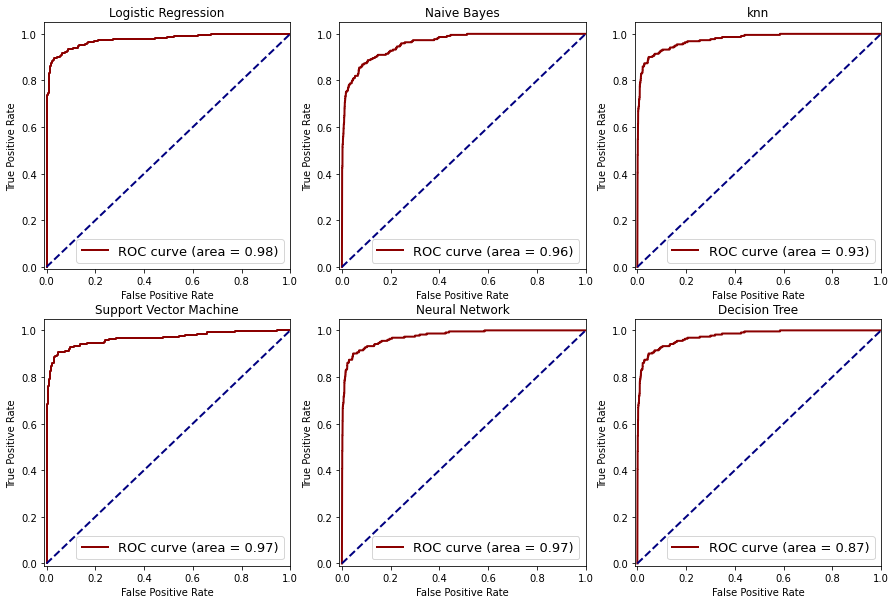

In [ ]:
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test.values,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test.values,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

pred_nn = nn.predict_proba(X_test)[:,1]
fpr_nn,tpr_nn,_ = roc_curve(y_test.values,pred_nn)
roc_auc_nn = auc(fpr_nn,tpr_nn)

pred_neigh = neigh.predict_proba(X_test)[:,1]
fpr_neigh,tpr_neigh,_ = roc_curve(y_test.values,pred_neigh)
roc_auc_neigh = auc(fpr_neigh,tpr_neigh)

pred_dt = dt.predict_proba(X_test)[:,1]
fpr_dt,tpr_dt,_ = roc_curve(y_test.values,pred_dt)
roc_auc_dt = auc(fpr_dt,tpr_dt)

f, axes = plt.subplots(2, 3,figsize=(15,10))
axes[0,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Neural Network')
axes[1,1].legend(loc='lower right', fontsize=13);

axes[0,2].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_neigh))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'knn')
axes[0,2].legend(loc='lower right', fontsize=13);

axes[1,2].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_dt))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Decision Tree')
axes[1,2].legend(loc='lower right', fontsize=13);

Text(570.5454545454544, 0.5, 'Actual Value')

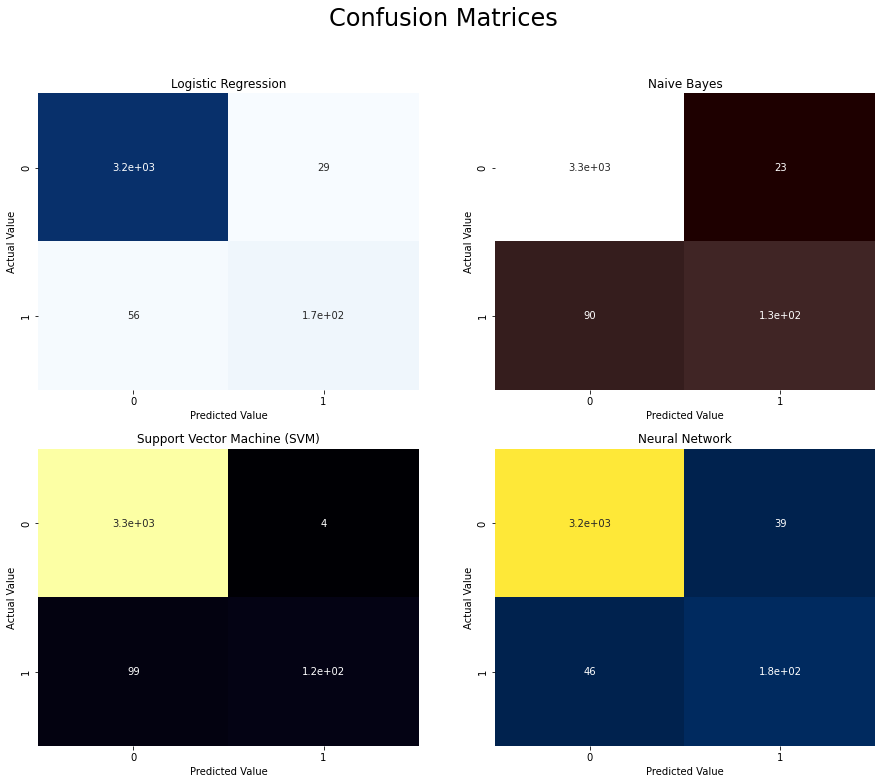

In [ ]:
lr_cm=confusion_matrix(y_test.values, lr.predict(X_test))
nb_cm=confusion_matrix(y_test.values,nb.predict(X_test))
svm_cm=confusion_matrix(y_test.values, svm.predict(X_test))
nn_cm=confusion_matrix(y_test.values, nn.predict(X_test))
knn_cm=confusion_matrix(y_test.values, neigh.predict(X_test))
dt_cm=confusion_matrix(y_test.values, dt.predict(X_test))
plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,2,1)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, annot = True, cmap="Blues",cbar=False);
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

plt.subplot(2,2,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, annot = True, cmap="pink",cbar=False);
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

plt.subplot(2,2,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, annot = True, cmap="inferno",cbar=False);
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

plt.subplot(2,2,4)
plt.title("Neural Network")
sns.heatmap(nn_cm, annot = True, cmap="cividis",cbar=False);
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

Text(570.5454545454544, 0.5, 'Actual Value')

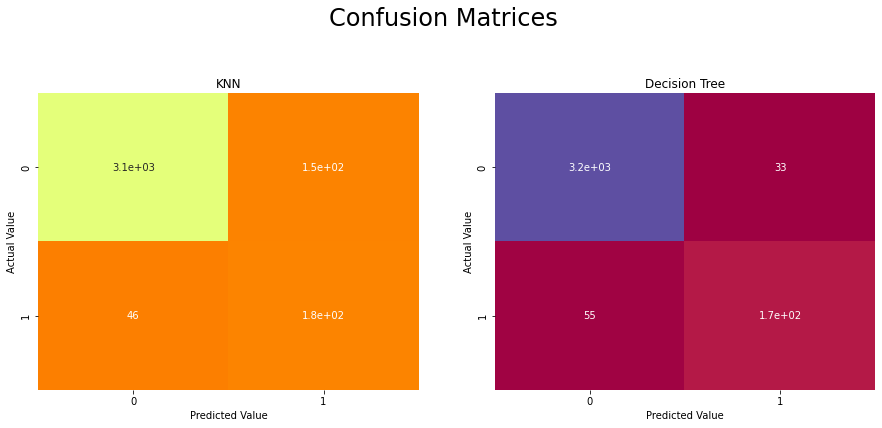

In [ ]:
plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)
plt.subplot(2,2,1)
plt.title("KNN")
sns.heatmap(knn_cm, annot = True, cmap="Wistia_r",cbar=False);
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

plt.subplot(2,2,2)
plt.title("Decision Tree")
sns.heatmap(dt_cm, annot = True, cmap="Spectral",cbar=False);
plt.xlabel('Predicted Value')
plt.ylabel('Actual Value')

In [ ]:
print("Logistic Regression")
print(mt.classification_report(y_test, lr.predict(X_test)))
print("\n Naive Bayes")
print(mt.classification_report(y_test, nb.predict(X_test)))
print("\n Support Vector Machine (SVM)")
print(mt.classification_report(y_test, svm.predict(X_test)))
print("\n Neural Network")
print(mt.classification_report(y_test, nn.predict(X_test)))
print("\n KNN")
print(mt.classification_report(y_test, neigh.predict(X_test)))
print("\n Decision Tree")
print(mt.classification_report(y_test, dt.predict(X_test)))

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3274
           1       0.85      0.75      0.80       222

    accuracy                           0.98      3496
   macro avg       0.92      0.87      0.89      3496
weighted avg       0.97      0.98      0.97      3496


 Naive Bayes
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3274
           1       0.85      0.59      0.70       222

    accuracy                           0.97      3496
   macro avg       0.91      0.79      0.84      3496
weighted avg       0.97      0.97      0.96      3496


 Support Vector Machine (SVM)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3274
           1       0.97      0.55      0.70       222

    accuracy                           0.97      3496
   macro avg       0.97      0.78      0.84      3496
weighted 